100%|█████████████████████████████████████████████████████████████████| 300/300 [03:34<00:00,  1.40it/s, ELBO=-1.44e+08]


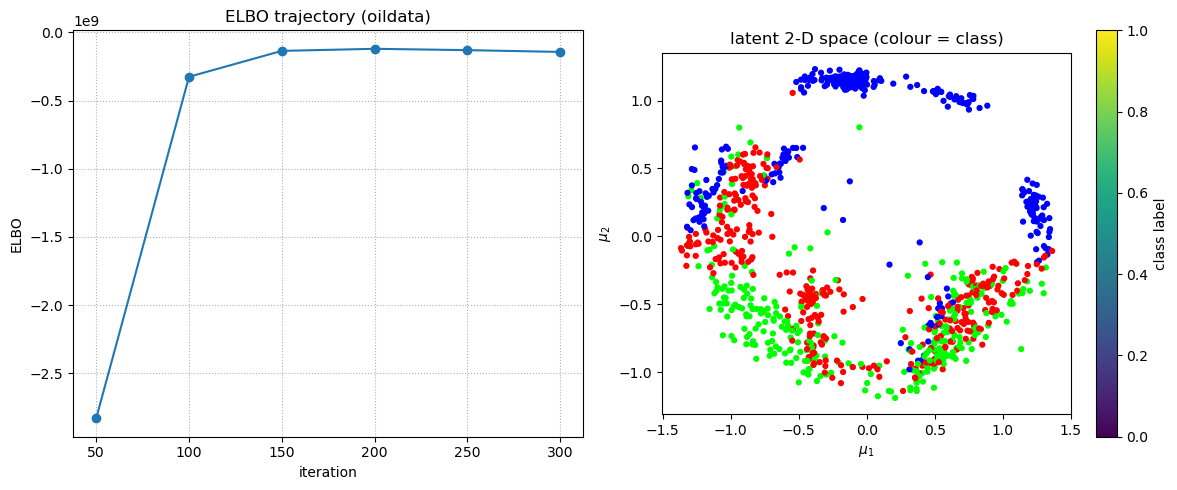

In [1]:
import math, torch, tqdm, matplotlib.pyplot as plt
import urllib.request, tarfile, numpy as np
from sklearn.decomposition import PCA

plt.rcParams["figure.autolayout"] = True
torch.set_default_dtype(torch.float64)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───────────── helpers ─────────────
def rho(t, t0=50., κ=0.9):
    return (t0 + t) ** (-κ)

# ─────── load oildata ───────
url = "http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/resources/3PhData.tar.gz"
urllib.request.urlretrieve(url, '3PhData.tar.gz')
with tarfile.open('3PhData.tar.gz', 'r') as f:
    f.extract('DataTrn.txt')
    f.extract('DataTrnLbls.txt')

Y_np = np.loadtxt('DataTrn.txt')
labels_np = np.loadtxt('DataTrnLbls.txt').astype(int)

Y = torch.tensor(Y_np, device=DEV)
labels = torch.tensor(labels_np, device=DEV)
N, D = Y.shape
Q = 2  # latent dimension remains 2

# ───── init latent mu_x ─────
with torch.no_grad():
    pca_init = PCA(n_components=Q).fit_transform(Y.cpu().numpy())
    mu_init = torch.tensor(pca_init, device=DEV)

# ─────── kernel + inducing grid ───────
sqrtM = 8
grid = torch.linspace(-1.5, 1.5, sqrtM, device=DEV)
Z = torch.stack(torch.meshgrid(grid, grid, indexing='ij'), -1).reshape(-1, Q)
M = Z.size(0)

log_sf2 = torch.tensor(0., device=DEV, requires_grad=True)
log_alpha = torch.zeros(Q, device=DEV, requires_grad=True)
log_beta_inv = torch.tensor(-3., device=DEV, requires_grad=True)

def se_kernel(x, z):
    a = log_alpha.exp()
    diff2 = (x.unsqueeze(-2) - z)**2
    return log_sf2.exp() * torch.exp(-0.5 * (diff2 * a).sum(-1))

def Kmm():
    return se_kernel(Z, Z) + 1e-6 * torch.eye(M, device=DEV)

def noise_var():
    return log_beta_inv.exp()

# ─────── q(U) natural params ───────
with torch.no_grad():
    s2_u = torch.full((D, M), 1e-2, device=DEV)
    h_u = torch.zeros_like(s2_u)
    lam_u = -0.5 / s2_u
for T in (h_u, lam_u): T.requires_grad_(False)

def sample_U():
    eps = torch.randn_like(h_u)
    var = -0.5 / lam_u
    return h_u * var + eps * torch.sqrt(var)

# ─────── q(x_n|U) ───────
mu_x = mu_init.clone().detach().requires_grad_()
log_s2x = torch.full_like(mu_x, -2.0, requires_grad=True)
inner_opt = torch.optim.Adam([mu_x, log_s2x], lr=1e-2)

# ─────── psi-stats ───────
def psi_stats(mu, s2):
    sf2, a = log_sf2.exp(), log_alpha.exp()
    S = mu.size(0)

    psi0 = sf2.expand(S)

    d1 = a * s2 + 1.
    c1 = d1.rsqrt().prod(-1, keepdim=True)
    diff = mu.unsqueeze(1) - Z
    psi1 = sf2 * c1 * torch.exp(-0.5 * ((a * diff**2) / d1.unsqueeze(1)).sum(-1))

    d2 = a * s2 + 2.
    c2 = d2.rsqrt().prod(-1, keepdim=True)
    ZZ = Z.unsqueeze(1) - Z.unsqueeze(0)
    distMM = (a * ZZ**2).sum(-1)
    mid = (Z.unsqueeze(1) + Z.unsqueeze(0)) / 2.
    mu_c2 = (mu[:, None, None, :] - mid)**2
    expo = torch.exp(-0.25 * distMM - 0.5 * ((a * mu_c2) / d2[:, None, None, :]).sum(-1))
    psi2 = sf2**2 * c2.unsqueeze(-1) * expo
    return psi0, psi1, psi2

# ─────── local ELBO ───────
def local_terms(idxs, U, mu_loc, log_s2_loc):
    Km, Lm = Kmm(), torch.linalg.cholesky(Kmm())
    mu, s2 = mu_loc[idxs], log_s2_loc[idxs].exp()
    psi0, psi1, psi2 = psi_stats(mu, s2)

    A = torch.cholesky_solve(psi1.T, Lm).T
    fmu = A @ U.T
    tr = torch.cholesky_solve(psi2, Lm).diagonal(0, -2, -1).sum(-1)
    sigma2 = (noise_var() + psi0 - tr).clamp_min(1e-8)

    log_like = (-0.5 * math.log(2 * math.pi)
                - 0.5 * sigma2.log()[:, None]
                - 0.5 * (Y[idxs] - fmu)**2 / sigma2[:, None]).sum(-1)
    kl_x = 0.5 * ((s2 + mu**2) / 5 - s2.log() + math.log(5) - 1).sum(-1)
    return (log_like - kl_x).mean(), (psi1, psi2, sigma2)

# ─────── KL[q(U)||p(U)] ───────
def KL_U():
    Km, Lm = Kmm(), torch.linalg.cholesky(Kmm())
    Kin_diag = torch.cholesky_solve(torch.eye(M, device=DEV), Lm).diag()
    var_u, mean_u = -0.5 / lam_u, h_u * (-0.5 / lam_u)
    tr = (Kin_diag * var_u).sum()
    quad = (Kin_diag * mean_u**2).sum()
    logdet_p = D * 2 * Lm.diagonal().log().sum()
    logdet_q = var_u.log().sum()
    return 0.5 * (tr + quad - D * M + logdet_p - logdet_q)

@torch.no_grad()
def full_ELBO():
    return local_terms(torch.arange(N, device=DEV), sample_U(), mu_x, log_s2x)[0] - KL_U()

# ─────── optimisation loop ───────
T_TOTAL, BATCH, INNER = 300, 128, 6
hyp_opt = torch.optim.Adam([log_sf2, log_alpha, log_beta_inv], lr=2e-4)
WARM = 50

eh, it = [], []
bar = tqdm.trange(1, T_TOTAL + 1, ncols=120)
for t in bar:
    idx = torch.randint(0, N, (BATCH,), device=DEV)

    # E-step
    for _ in range(INNER):
        inner_opt.zero_grad(set_to_none=True)
        le, _ = local_terms(idx, sample_U().detach(), mu_x, log_s2x)
        (-le).backward()
        inner_opt.step()
        mu_x.detach_().requires_grad_()
        log_s2x.detach_().requires_grad_()

    # M-step: hypers
    U_s, rho_variable = sample_U(), rho(t)
    le, (psi1, _, sigma2) = local_terms(idx, U_s, mu_x, log_s2x)
    if t >= WARM:
        hyp_opt.zero_grad(set_to_none=True)
        (-(le - KL_U())).backward()
        hyp_opt.step()

    # M-step: nat params
    with torch.no_grad():
        Lm = torch.linalg.cholesky(Kmm())
        A = torch.cholesky_solve(psi1.detach().T, Lm).T
        r_n = ((Y[idx] / sigma2[:, None])[:, :, None]) * A[:, None, :]
        q_n = -0.5 * (A**2) / sigma2[:, None]
        r_t = r_n.sum(0)
        q_t = q_n.sum(0).unsqueeze(0).expand(D, -1)
        deltaU = U_s - h_u * (-0.5 / lam_u)
        r_t += 2 * q_t * deltaU
        scale = N / BATCH
        lambda0 = -0.5 * torch.cholesky_solve(torch.eye(M, device=DEV), Lm).diag()
        h_u += rho_variable * (scale * r_t - h_u)
        lam_u += rho_variable * (lambda0.unsqueeze(0) + scale * q_t - lam_u)
        lam_u.clamp_(max=-1e-8)

    if t % 50 == 0:
        e = full_ELBO().item()
        eh.append(e)
        it.append(t)
        bar.set_postfix({"ELBO": f"{e:.2e}"})

# ─────── visuals ───────
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(it, eh, "-o")
ax[0].grid(ls=":")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("ELBO")
ax[0].set_title("ELBO trajectory (oildata)")

mu = mu_x.detach().cpu()
sc = ax[1].scatter(mu[:, 0], mu[:, 1], c=labels.cpu(), cmap="brg", s=12)
ax[1].set_xlabel(r"$\mu_1$")
ax[1].set_ylabel(r"$\mu_2$")
ax[1].set_aspect("equal")
ax[1].set_title("latent 2‑D space (colour = class)")
plt.colorbar(sc, ax=ax[1], label="class label")
plt.show()
